<a href="https://colab.research.google.com/github/rajeshpahari/Deep-Learning/blob/main/Pytorch_Dropout_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
###############Import Libraries
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset


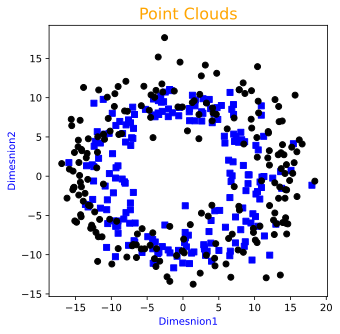

In [72]:
################Create Data
nPerclust=200

#Theta ...for deviations
th=np.linspace(0,4*np.pi,nPerclust)

#radious
r1=10
r2=15

#Generate data
a= [r1*np.cos(th)+np.random.randn(nPerclust)*3,
    r1*np.sin(th)+np.random.randn(nPerclust)]

b= [r2*np.cos(th)+np.random.randn(nPerclust),
    r1*np.sin(th)+np.random.randn(nPerclust)*3]

#True label
label_np=np.vstack((np.zeros((nPerclust,1)),np.ones((nPerclust,1))))

#concatenate a & b in a matrix
data_np=np.hstack((a,b)).T

#convert data & labels in tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(label_np).float()

##Show the data
fig=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.xlabel('Dimesnion1',color='b')
plt.ylabel('Dimesnion2',color='b')
plt.title('Point Clouds',fontsize=16,color='orange')
plt.show()

In [73]:
# #############Seperate data in train,devset & test set using dataloader & Scikit learn

# ## Parameter to devide train devset and testset
# partition=[.8,.1,.1]

# ## lets first devide data & labels in train and temp set
# train_data, temp_data, train_label, temp_label = train_test_split(data, labels, train_size=partition[0])
# print('\n---------------Display for understanding------------------\n')
# print('Trainshape:',train_data.shape)
# print('Tempshape:',temp_data.shape)
# print('Train data size from whole data is: %g%%' %(train_data.shape[0]/data.shape[0]*100))
# print('Temp data size from whole data is: %g%%' %(temp_data.shape[0]/data.shape[0]*100))
# print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n")
# #########lets now devide the temp data in devset and test set

# #Define how much of temp data should be splited as devset
# split=partition[1]/np.sum(partition[1:])

# #Split temp to deset and testset

# dev_data, test_data, dev_label, test_label = train_test_split(temp_data, temp_label, train_size=split)
# print('Trainshape:',train_data.shape)
# print('Devset shape:',dev_data.shape)
# print('Test shape:',test_data.shape)
# print('\n.................................\n')
# print('Train data size from whole data is: %g%%' %(train_data.shape[0]/data.shape[0]*100))
# print('Devset data size from whole data is: %g%%' %(dev_data.shape[0]/data.shape[0]*100))
# print('Testset data size from whole data is: %g%%' %(test_data.shape[0]/data.shape[0]*100))


In [74]:
############ Splilt the data in train and test data using data loader

train_data, test_data, train_label, test_label = train_test_split(data, labels, test_size=.2)

#convert the data in pytorch tensor
train_data=TensorDataset(train_data,train_label)
test_data=TensorDataset(test_data,test_label)

#Translate in dataLoader Objects
batchSize=16
train_loader=DataLoader(train_data,batch_size=batchSize,shuffle=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [75]:
################Create the Model
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    ##Layers
    self.input=nn.Linear(2,128)
    self.hidden=nn.Linear(128,128)
    self.output=nn.Linear(128,1)

    #Parameters
    self.dr=dropoutRate

  #Forwrad Pass
  def forward(self,x):
    
    ##Input Layer
    #Pass the data through input layer
    x=F.relu(self.input(x))
    #dropout after input layer
    x=F.dropout(x,p=self.dr,training=self.training) #dropout is switch on in training mode

    ##Hidden Layer
    #Pass the data through hidden layer
    x=F.relu(self.hidden(x))
    #dropout after Hidden layer
    x=F.dropout(x,p=self.dr,training=self.training) #dropout is switch on in training mode

    ##Output Layer
    x=self.output(x)
    
    return x



In [76]:
###Test the Model...This is just for test for syntax checking
tmpnet=theModelClass(.25)

#Run some random data
tmpdata=torch.randn((10,2))
yHat=tmpnet(tmpdata)
yHat

tensor([[ 0.0646],
        [-0.0433],
        [-0.0424],
        [-0.0566],
        [-0.0676],
        [-0.0413],
        [ 0.0656],
        [-0.2107],
        [ 0.2459],
        [-0.0169]], grad_fn=<AddmmBackward0>)

In [77]:
############Function to Create & Train Net

def CreateANewModel(dropoutrate):

  #Instance of modelclass
  ANNQC=theModelClass(dropoutrate)
  #Lossfunction
  lossfunc=nn.BCEWithLogitsLoss()

  #optimizer
  optimizer=torch.optim.SGD(ANNQC.parameters(),lr=.0001)

  return ANNQC,lossfunc,optimizer



In [78]:
######################Train The Model

##Training parameter
numepochs=1000

#Training Model
def trainModel(ANNQC,lossfunc,optimizer):

  #Initialize the accuracy
  trainacc=[]
  testacc=[]

  

  #Loop Over Epochs
  for i in range(numepochs):
    #Switch on Training Mode
    ANNQC.train()

    #Calculate batch accuracy in each epoch
    batchacc=[]
    # Second loop
    for X,y in train_loader:

      #Forward Pass
      yHat=ANNQC(X)
      loss=lossfunc(yHat,y)

      #Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #Compute Batch accuracy for training
      batchacc.append(100*torch.mean(((yHat>.5)==y).float()))

    #What is training accuracy?  mean of batch accuracy is the whole training accuracy
    trainacc.append(np.mean(batchacc))

    ##Test Accuracy
    ANNQC.eval()# Swutch off the training
    X,y=next(iter(test_loader))
    yHat=ANNQC(X)

    testacc.append(100*torch.mean(((yHat>.5)==y).float()))

  #function output
  return trainacc,testacc


In [79]:

#####################Test The Model
dropoutrate=.0
ANNQC,lossfunc,optimizer=CreateANewModel(dropoutrate)

#Trainmodel
trainacc,testacc=trainModel(ANNQC,lossfunc,optimizer)





In [80]:
#Create 1D Smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

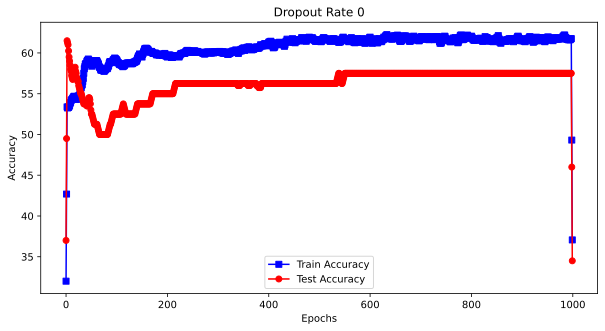

In [81]:
#Plot the result
fig=plt.figure(figsize=(10,5))

plt.plot(smooth(trainacc),'bs-')
plt.plot(smooth(testacc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy','Test Accuracy'])
plt.title('Dropout Rate %g' %dropoutrate);

In [84]:
#########Experiments with Dropout rates
dropoutRates=np.arange(10)/10
results=np.zeros((len(dropoutRates),2))
#results

for di in range(len(dropoutRates)):
  
  #Create & Train Model
  ANNQC,lossfunc,optimizer=CreateANewModel(dropoutrate)
  trainacc,testacc=trainModel(ANNQC,lossfunc,optimizer)

  #Store Results of acuract from last 100 epochs
  results[di,0]=np.mean(trainacc)
  results[di,1]=np.mean(testacc)



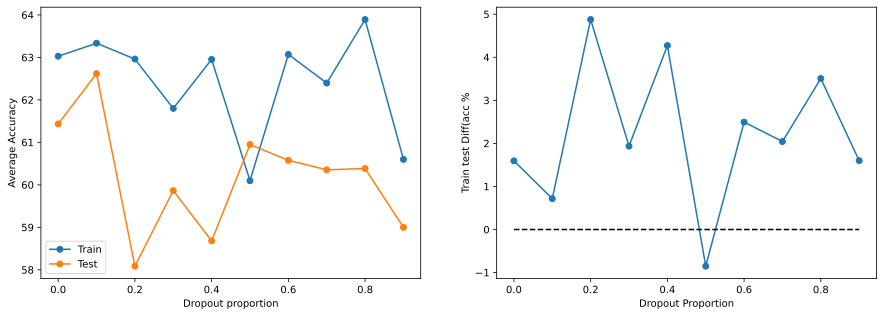

In [85]:
##############Plot the experiments
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average Accuracy')
ax[0].legend(['Train','Test'])


ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0.0,0.9],[0,0],'k--')
ax[1].set_xlabel('Dropout Proportion')
ax[1].set_ylabel('Train test Diff(acc %')


plt.show()